In [ ]:
import pandas as pd
import datetime

# 元となる脆弱性のデータ

In [ ]:
vul_origin_data = pd.read_csv("./../vulnerability/npm_vul_data_before_2019_last_100.csv",delimiter=",")
vul_origin_data

## 重複した脆弱性データがないか確認

In [ ]:
vul_origin_data.groupby(["vulnerability_name", "package_name", "project_id"]).size().sort_values(ascending=False)

# 脆弱性影響の解析後データを分析

In [ ]:
vul_data = pd.read_csv("./affected_packages_npm_with_all.csv",delimiter=",")
vul_data

## 影響を与えたパッケージ数のランキング

In [ ]:
vul_data.groupby("vul_project_id").size().sort_values(ascending=False)

## 影響を受けた期間を計算

- 脆弱性受け終わりの時刻が現在時刻(2023年1月1日)付近であれば、脆弱性受け終わりの時刻を'2020-01-12 00:00:00'に上書きする
    - データセットの構築時の最新時刻に揃える
    - データセット: https://libraries.io/data

In [ ]:
parsed_datetime = datetime.datetime(2023, 1, 1, 0, 0, 0, 0)
vul_end_last_datetime = datetime.datetime(2020, 1, 12, 0, 0, 0, 0)

vul_data["vul_end_datetime"] = vul_data["vul_end_datetime"].where(vul_data["vul_end_timestamp"] < parsed_datetime.timestamp(), vul_end_last_datetime.strftime('%Y-%m-%d %H:%M:%S'))
vul_data["vul_end_timestamp"] = vul_data["vul_end_timestamp"].where(vul_data["vul_end_timestamp"] < parsed_datetime.timestamp(), vul_end_last_datetime.timestamp())
vul_data["vul_months"] = (vul_data["vul_end_timestamp"] - vul_data["vul_start_timestamp"]) / (3600 * 24 * 30)
vul_data
vul_data["status"] = vul_data["vul_end_timestamp"] < vul_end_last_datetime.timestamp()

## データの分布


### 脆弱性の存続期間

In [ ]:
vul_data["vul_months"].hist(bins=50)

### semver準拠タイプごとの影響を受けたパッケージ数

- 1: (本番開発リリース)準拠している
- 2: (本番開発リリース)semverより緩い制約
- 3: (本番開発リリース)semverより厳しい制約
- 4: (初期開発リリース)準拠している
- 5: (初期開発リリース)semverより緩い制約

In [ ]:
vul_data.groupby("compliantType").size()

# サバイバル分析

- ドキュメント: https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.nonparametric.kaplan_meier_estimator.html
    - Kaplan-Meier推定
        - https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%97%E3%83%A9%E3%83%B3%EF%BC%9D%E3%83%9E%E3%82%A4%E3%83%A4%E3%83%BC%E6%8E%A8%E5%AE%9A%E9%87%8F
    - 打ち切りデータもあってよい

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import numpy as np

In [ ]:
vul_data_compliant = vul_data[vul_data["compliantType"] == 1]
vul_data_permissive = vul_data[vul_data["compliantType"] == 2]
vul_data_restrictive = vul_data[vul_data["compliantType"] == 3]

### 生存関数

- 期間が長くなっても、Compliantな脆弱性が他に比べて生き残っている

Text(0.5, 0, 'time $t$')

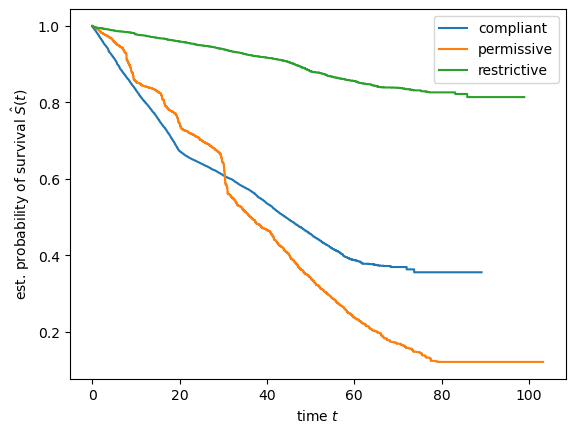

In [94]:
cph_compliant = CoxPHFitter()
cph_compliant.fit(pd.concat([vul_data_compliant["vul_months"], vul_data_compliant["status"].map(lambda x: 1 if x else 0)], axis=1), "vul_months", "status", robust=True)
survival_f_compliant = cph_compliant.predict_survival_function(np.arange(0, 100, 1000))


cph_permissive = CoxPHFitter()
cph_permissive.fit(pd.concat([vul_data_permissive["vul_months"], vul_data_permissive["status"].map(lambda x: 1 if x else 0)], axis=1), "vul_months", "status", robust=True)
survival_f_permissive = cph_permissive.predict_survival_function(np.arange(0, 100, 1000))

cph_restrictive = CoxPHFitter()
cph_restrictive.fit(pd.concat([vul_data_restrictive["vul_months"], vul_data_restrictive["status"].map(lambda x: 1 if x else 0)], axis=1), "vul_months", "status", robust=True)
survival_f_restrictive = cph_restrictive.predict_survival_function(np.arange(0, 100, 1000))


plt.step(survival_f_compliant.index, survival_f_compliant[0], where="post", label="compliant")
plt.step(survival_f_permissive.index, survival_f_permissive[0], where="post", label="permissive")
plt.step(survival_f_restrictive.index, survival_f_restrictive[0], where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## 準拠タイプごとに脆弱性影響の生存期間を分析

### Compliant

In [ ]:
vul_data_compliant["vul_months"].describe()

In [ ]:
vul_data_compliant["vul_months"].hist(bins=30)

### Permissive

- Compliantより生存期間が長い
    - なんで？

In [ ]:
vul_data_permissive["vul_months"].describe()

In [ ]:
vul_data_permissive["vul_months"].hist(bins=30)

### Restrictive

In [ ]:
vul_data_restrictive["vul_months"].hist(bins=30)

In [ ]:
vul_data_restrictive["vul_months"].describe()

In [ ]:
vul_data_restrictive["vul_months"][vul_data_restrictive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()].hist(bins=50)